In [25]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from get_metrics import *
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

print("Libraries imported")

Libraries imported


In [26]:
datadir = '/content/drive/MyDrive/Project/Dataset'
modeldir = '/content/drive/MyDrive/Project/Models'
trainingset = datadir+'/train/'
testingset = datadir+'/test/'

img_size = (320,320)
batch_size = 8

In [27]:
mean1, std1 = [0.3017, 0.3017, 0.3017], [0.1913, 0.1913, 0.1913]
mean2, std2 = [0.3176, 0.3176, 0.3176], [0.1881, 0.1881, 0.1881]

data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize(img_size),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean1, 
                                                  std = std1)
    ]),
    'test': transforms.Compose([
                                transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean2, 
                                                  std = std2)
    ]),
                   }

print("Initializing Datasets and Dataloaders...\n")

image_datasets = {'train' : datasets.ImageFolder(trainingset, data_transforms['train']), 
                  'test' : datasets.ImageFolder(testingset, data_transforms['test'])}

dataloaders = {'train' : torch.utils.data.DataLoader(image_datasets['train'], 
                                                     batch_size = batch_size, shuffle = True,
                                                     num_workers=4, pin_memory=True),
               'test' : torch.utils.data.DataLoader(image_datasets['test'], 
                                                     batch_size = batch_size, shuffle = True,
                                                     num_workers=4, pin_memory=True)}

device = torch.device("cuda:0")
dataset_sizes = {'train' : len(image_datasets['train']),
                 'test' : len(image_datasets['test'])}
print("Initialized!")

Initializing Datasets and Dataloaders...

Initialized!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [28]:
# Class names convert to index
image_datasets['train'].class_to_idx
class_names=image_datasets['train'].classes
print(">>Class Names: {}\n".format(image_datasets['train'].classes))
print(">>Class Index: {}\n".format(image_datasets['train'].class_to_idx))
print(">>Number of images in training={}\n".format(dataset_sizes['train']))
print(">>Number of images in test={}\n".format(dataset_sizes['test']))
print("    Number of steps for training set={}\n".format(len(dataloaders['train'])))
print("    Number of steps for test set={}\n".format(len(dataloaders['test']))) 

>>Class Names: ['abnormal', 'normal']

>>Class Index: {'abnormal': 0, 'normal': 1}

>>Number of images in training=8379

>>Number of images in test=563

    Number of steps for training set=1048

    Number of steps for test set=71



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


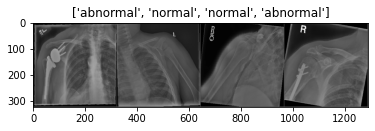

In [29]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean1)
    std = np.array(std1)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs = [inputs[x] for x in [0,1,2,3]]
classes = [classes[x] for x in [0,1,2,3]]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Building the Ensemble Learning Model**

In [30]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_weights = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  ghost=True
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    for phase in ['train', 'test']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        #forward, track history only if we are in training
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          #backward + optimize only if we are in training
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      #storing losses and accuracy per epochs to plot metrics graph

      if phase == 'train':
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase == 'test':
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        test_losses.append(epoch_loss)
        test_acc.append(epoch_acc)
      torch.cuda.empty_cache()


      #deep copy the model
      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_weights = copy.deepcopy(model.state_dict())
    
    print()
    torch.cuda.empty_cache()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_weights)
  torch.save(best_model_weights, "./model.pth")
  return model


In [34]:
class SpinalNet_ResNext_50(nn.Module):
  def __init__(self):
    super(SpinalNet_ResNext_50, self).__init__()

    self.fc_spinal_layer1 = nn.Sequential(
        nn.Linear(1024, 20),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer2 = nn.Sequential(
        nn.Linear(1024+20, 20),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer3 = nn.Sequential(
        nn.Linear(1024+20, 20),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer4 = nn.Sequential(
        nn.Linear(1024+20, 20),
        nn.ReLU(inplace=True),)
    self.fc_out = nn.Sequential(
        nn.Linear(20*4, 2),
        nn.Sigmoid())
    
  def forward(self, x): 
    x1 = self.fc_spinal_layer1(x[:, 0:1024])
    x2 = self.fc_spinal_layer2(torch.cat([x[:, 1024:2*1024], x1], dim=1))
    x3 = self.fc_spinal_layer3(torch.cat([x[:, 0:1024], x2], dim=1))
    x4 = self.fc_spinal_layer4(torch.cat([x[:, 1024:2*1024], x3], dim=1))   

    x = torch.cat([x1, x2], dim=1)
    x = torch.cat([x, x3], dim=1)
    x = torch.cat([x, x4], dim=1)

    x = self.fc_out(x)

    return x

In [41]:
class SpinalNet_DenseNet_201(nn.Module):
  def __init__(self):
    super(SpinalNet_DenseNet_201, self).__init__()

    self.fc_spinal_layer1 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(960, 240),
        nn.BatchNorm1d(240),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer2 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(960+240, 240),
        nn.BatchNorm1d(240),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer3 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(960+240, 240),
        nn.BatchNorm1d(240),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer4 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(960+240, 240),
        nn.BatchNorm1d(240),
        nn.ReLU(inplace=True),)
    self.fc_out = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(240*4, 2),
        nn.Sigmoid(),)
  
  def forward(self, x):
    x1 = self.fc_spinal_layer1(x[:, 0:960])
    x2 = self.fc_spinal_layer2(torch.cat([x[:, 960:2*960], x1], dim=1))
    x3 = self.fc_spinal_layer3(torch.cat([x[:, 0:960], x2], dim=1))
    x4 = self.fc_spinal_layer4(torch.cat([x[:, 960:2*960], x3], dim=1))

    x = torch.cat([x1, x2], dim=1)
    x = torch.cat([x, x3], dim=1)
    x = torch.cat([x, x4], dim=1)

    x = self.fc_out(x)
    return x

In [36]:
resnext50 =models.resnext50_32x4d(pretrained=False)
resnext50.fc =  SpinalNet_ResNext_50()
resnext50.load_state_dict(torch.load(modeldir+'/ResNeXt50SP.pth'))
resnext50=resnext50.to(device)
resnext50.fc.fc_out=nn.Linear(80,80)

In [37]:
densenet169 = models.densenet169(pretrained=False)
num_ftrs = densenet169.classifier.in_features
densenet169.classifier = nn.Sequential(nn.Linear(num_ftrs, 2), nn.Sigmoid())
densenet169.load_state_dict(torch.load(modeldir+'/DenseNet169FC.pth'))
densenet169 = densenet169.to(device)
densenet169.classifier = nn.Linear(1664, 1664)

In [42]:
densenet201 = models.densenet201(pretrained=False)
densenet201.classifier = SpinalNet_DenseNet_201()
densenet201.load_state_dict(torch.load(modeldir+'/DenseNet201SP.pth'))
densenet201 = densenet201.to(device)
densenet201.classifier.fc_out=nn.Linear(960,960)

In [43]:
for param in resnext50.parameters():
    param.requires_grad_(False)

for param in densenet169.parameters():
    param.requires_grad_(False)
    
for param in densenet201.parameters():
    param.requires_grad_(False)

In [44]:
class EnsembleLearning1(nn.Module):
  def __init__(self):
    super(EnsembleLearning1, self).__init__()

    self.modelA = resnext50
    self.modelB = densenet169
    self.modelC = densenet201

    self.hidden = nn.Linear(2704, 2704)
    self.classifier = nn.Linear(2704, 2)

  def forward(self, x):

    x1 = self.modelA(x.clone())
    x1 = x1.view(x1.size(0), -1)
    x2 = self.modelB(x)
    x2 = x2.view(x2.size(0), -1)
    x3 = self.modelC(x)
    x3 = x3.view(x3.size(0), -1)

    x = torch.cat((x1,x2,x3), dim=1)
    x = self.hidden(torch.softmax(x, dim=1))
    x = self.classifier(torch.sigmoid(x))

    return x

In [46]:
enslearn1 = EnsembleLearning1()
enslearn1 = enslearn1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(enslearn1.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [48]:
enslearn1 = train_model(enslearn1, criterion, optimizer, exp_lr_scheduler, 40)

Epoch 0/39
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6721 Acc: 0.5837
train Loss: 0.6721 Acc: 0.5837
test Loss: 0.6422 Acc: 0.5790
test Loss: 0.6422 Acc: 0.5790

Epoch 1/39
----------
train Loss: 0.6117 Acc: 0.6944
train Loss: 0.6117 Acc: 0.6944
test Loss: 0.5697 Acc: 0.7016
test Loss: 0.5697 Acc: 0.7016

Epoch 2/39
----------
train Loss: 0.5525 Acc: 0.7503
train Loss: 0.5525 Acc: 0.7503
test Loss: 0.5229 Acc: 0.8099
test Loss: 0.5229 Acc: 0.8099

Epoch 3/39
----------
train Loss: 0.5098 Acc: 0.7925
train Loss: 0.5098 Acc: 0.7925
test Loss: 0.5176 Acc: 0.7957
test Loss: 0.5176 Acc: 0.7957

Epoch 4/39
----------
train Loss: 0.4819 Acc: 0.8105
train Loss: 0.4819 Acc: 0.8105
test Loss: 0.4967 Acc: 0.8046
test Loss: 0.4967 Acc: 0.8046

Epoch 5/39
----------
train Loss: 0.4643 Acc: 0.8280
train Loss: 0.4643 Acc: 0.8280
test Loss: 0.4905 Acc: 0.7975
test Loss: 0.4905 Acc: 0.7975

Epoch 6/39
----------
train Loss: 0.4488 Acc: 0.8326
train Loss: 0.4488 Acc: 0.8326
test Loss: 0.5210 Acc: 0.8188
test Loss: 0.5210 Acc: 0.8188

Epoch 7

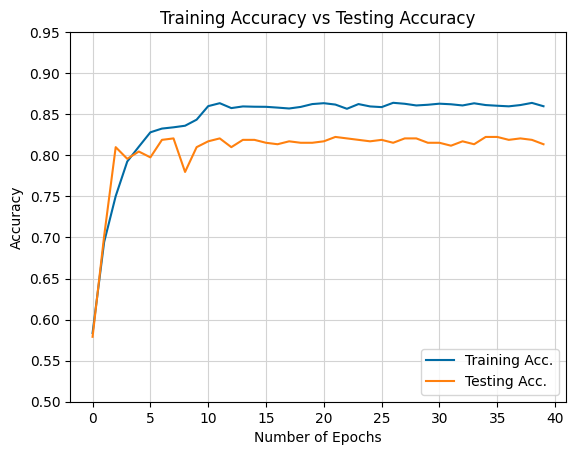

In [49]:
matplotlib.rcdefaults()
epochs=range(0, 40, 1)
plt.plot(epochs, train_acc, color='#006BA4')
plt.plot(epochs, test_acc, color='#FF800E')
plt.grid(b=True, which='major', color='lightgray')
plt.grid(b=True, which='minor', color='lightgray')
plt.xticks(np.arange(0, 45, 5))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 600
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Testing Accuracy")
plt.legend(['Training Acc.', 'Testing Acc.'],loc='lower right')

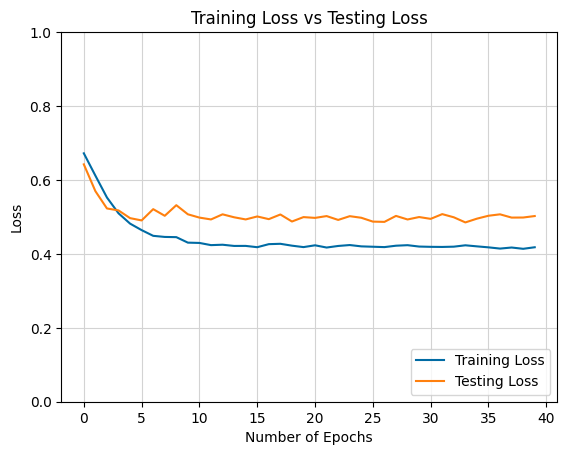

In [50]:
#This code block draw graph for loss
matplotlib.rcdefaults()
plt.plot(epochs, train_losses, color='#006BA4')
plt.plot(epochs, test_losses, color='#FF800E')
plt.grid(b=True, which='major', color='lightgray')
plt.grid(b=True, which='minor', color='lightgray')
plt.xticks(np.arange(0, 45, 5))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Testing Loss")
plt.legend(['Training Loss', 'Testing Loss'],loc='lower right')

In [51]:
get_metric.test_model(enslearn1,device,dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Correct Prediction: 463  Total Images: 563
Test Accuracy = 0.822380


In [53]:
actuals, predictions = get_metric.test_label_predictions(enslearn1, device, dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [54]:
get_metric.get_classification_report(actuals, predictions)

Classification Report :
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       278
           1       0.82      0.84      0.83       285

    accuracy                           0.82       563
   macro avg       0.82      0.82      0.82       563
weighted avg       0.82      0.82      0.82       563



Confusion matrix:
 [[224  54]
 [ 46 239]]


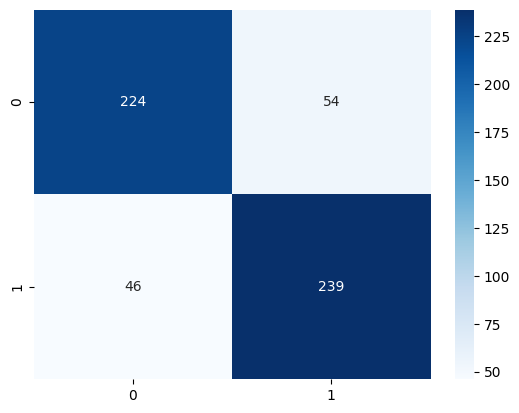

In [55]:
get_metric.get_confusion_matrix(actuals, predictions)

In [56]:
get_metric.get_cohen_kappa(actuals, predictions)

Kappa Score of this model:
 0.6445796823312542


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Auc Score For Each Class:  {0: 0.8722201186419286, 1: 0.8722201186419286}


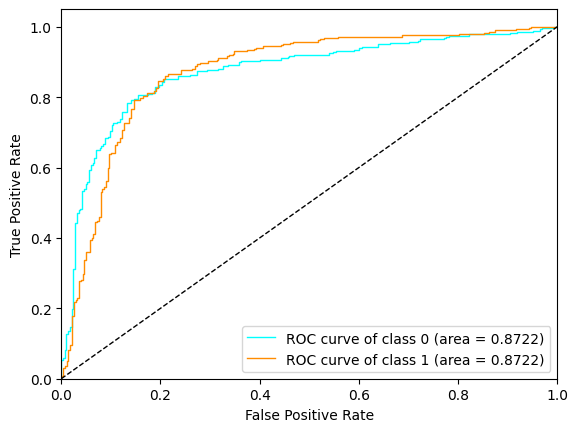

In [58]:
get_metric.get_roc_curves(enslearn1, device,  dataloaders['test'])